# Access CMIP6 zarr data from AWS using the osdf protocol and compute different precipitation statistics
- This workflow is an adaptation of https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/precip_frequency_change.html
- Also see, the paper https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-16-0684.1
- And the article https://climatedataguide.ucar.edu/climate-data/gpcp-daily-global-precipitation-climatology-project which inspired the workflow

## Table of Contents
- [Section 1: Introduction](#Section-1:-Introduction) 
- [Section 2: Select Dask Cluster](#Section-2:-Select-Dask-Cluster) 
- [Section 3: Data Loading](#Section-3:-Data-Loading) 
- [Section 4: Data Analysis](#Section-4:-Data-Analysis) 

## Section 1: Introduction
- Load python packkages
- Load catalog url

In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm
import intake
import fsspec
import seaborn as sns
import re
import aiohttp
from dask_jobqueue import PBSCluster
import pandas as pd
from xhistogram.xarray import histogram

/glade/derecho/scratch/harshah/tmp/ipykernel_37992/3451259092.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# import fsspec.implementations.http as fshttp
from pelicanfs.core import OSDFFileSystem,PelicanMap 

In [3]:
rda_scratch = '/glade/campaign/collections/rda/scratch/harshah'
rda_url     =  'https://data.rda.ucar.edu/'
# cat_url     = rda_url +  'd850001/catalogs/osdf/cmip6-aws/cmip6-osdf-zarr.json'
cat_url     = 'https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json'

## Section 2: Select Dask Cluster

#### Select the Dask cluster type
The default will be LocalCluster as that can run on any system.

If running on a HPC computer with a PBS Scheduler, set to True. Otherwise, set to False.

In [4]:
USE_PBS_SCHEDULER = True

If running on Jupyter server with Dask Gateway configured, set to True. Otherwise, set to False.

In [5]:
USE_DASK_GATEWAY = False

#### Python function for a PBS cluster

In [6]:
# Create a PBS cluster object
def get_pbs_cluster():
    """ Create cluster through dask_jobqueue.   
    """
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(
        job_name = 'dask-osdf-24',
        cores = 1,
        memory = '4GiB',
        processes = 1,
        local_directory = rda_scratch + '/dask/spill',
        log_directory = rda_scratch + '/dask/logs/',
        resource_spec = 'select=1:ncpus=1:mem=4GB',
        queue = 'casper',
        walltime = '3:00:00',
        #interface = 'ib0'
        interface = 'ext'
    )
    return cluster

#### Python function for a Gateway Cluster

In [7]:
def get_gateway_cluster():
    """ Create cluster through dask_gateway
    """
    from dask_gateway import Gateway

    gateway = Gateway()
    cluster = gateway.new_cluster()
    cluster.adapt(minimum=2, maximum=4)
    return cluster

In [8]:
def get_local_cluster():
    """ Create cluster using the Jupyter server's resources
    """
    from distributed import LocalCluster, performance_report
    cluster = LocalCluster()    

    cluster.scale(6)
    return cluster

#### Python logic for a Local Cluster
This uses True/False boolean logic based on the variables set in the previous cells

In [9]:
# Obtain dask cluster in one of three ways
if USE_PBS_SCHEDULER:
    cluster = get_pbs_cluster()
elif USE_DASK_GATEWAY:
    cluster = get_gateway_cluster()
else:
    cluster = get_local_cluster()

# Connect to cluster
from distributed import Client
client = Client(cluster)

In [10]:
# Scale the cluster and display cluster dashboard URL
n_workers =8
cluster.scale(n_workers)
client.wait_for_workers(n_workers = n_workers)
cluster

PBSCluster(bfdd887b, 'tcp://128.117.208.98:41657', workers=8, threads=8, memory=32.00 GiB)

## Section 3: Data Loading
- Load catalog and select data subset

In [11]:
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,709
grid_label,10
zstore,522217
dcpp_init_year,60


In [12]:
[eid for eid in col.df['experiment_id'].unique() if 'ssp' in eid]

['esm-ssp585-ssp126Lu',
 'ssp126-ssp370Lu',
 'ssp370-ssp126Lu',
 'ssp585',
 'ssp245',
 'ssp370-lowNTCF',
 'ssp370SST-ssp126Lu',
 'ssp370SST',
 'ssp370pdSST',
 'ssp370SST-lowCH4',
 'ssp370SST-lowNTCF',
 'ssp126',
 'ssp119',
 'ssp370',
 'esm-ssp585',
 'ssp245-nat',
 'ssp245-GHG',
 'ssp460',
 'ssp434',
 'ssp534-over',
 'ssp245-aer',
 'ssp245-stratO3',
 'ssp245-cov-fossil',
 'ssp245-cov-modgreen',
 'ssp245-cov-strgreen',
 'ssp245-covid',
 'ssp585-bgc']

In [13]:
# there is currently a significant amount of data for these runs
expts = ['historical', 'ssp585']

query = dict(
    experiment_id=expts,
    table_id='3hr',
    variable_id=['pr'],
    #member_id = 'r1i1p1f1',
    #activity_id = 'CMIP',
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset

,unique
activity_id,2
institution_id,3
source_id,4
experiment_id,2
member_id,18
table_id,1
variable_id,1
grid_label,2
zstore,24
dcpp_init_year,0


In [14]:
col_subset.df.groupby("source_id")[["experiment_id", "variable_id", "table_id","activity_id"]].nunique()

,experiment_id,variable_id,table_id,activity_id
source_id,,,,
BCC-CSM2-MR,2,1,1,2
CNRM-CM6-1,2,1,1,2
CNRM-ESM2-1,2,1,1,2
IPSL-CM6A-LR,2,1,1,2


In [15]:
col_subset.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,3hr,pr,gn,s3://cmip6-pds/CMIP6/CMIP/BCC/BCC-CSM2-MR/hist...,NaN,20190108
1,ScenarioMIP,BCC,BCC-CSM2-MR,ssp585,r1i1p1f1,3hr,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/BCC/BCC-CSM2-...,NaN,20190318
2,CMIP,CNRM-CERFACS,CNRM-CM6-1,historical,r1i1p1f2,3hr,pr,gr,s3://cmip6-pds/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM...,NaN,20180917
3,CMIP,CNRM-CERFACS,CNRM-CM6-1,historical,r2i1p1f2,3hr,pr,gr,s3://cmip6-pds/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM...,NaN,20181126
4,CMIP,CNRM-CERFACS,CNRM-CM6-1,historical,r3i1p1f2,3hr,pr,gr,s3://cmip6-pds/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM...,NaN,20190125
5,ScenarioMIP,CNRM-CERFACS,CNRM-CM6-1,ssp585,r1i1p1f2,3hr,pr,gr,s3://cmip6-pds/CMIP6/ScenarioMIP/CNRM-CERFACS/...,NaN,20190219
6,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r1i1p1f2,3hr,pr,gr,s3://cmip6-pds/CMIP6/CMIP/CNRM-CERFACS/CNRM-ES...,NaN,20181206
7,ScenarioMIP,CNRM-CERFACS,CNRM-ESM2-1,ssp585,r1i1p1f2,3hr,pr,gr,s3://cmip6-pds/CMIP6/ScenarioMIP/CNRM-CERFACS/...,NaN,20190328
8,CMIP,IPSL,IPSL-CM6A-LR,historical,r4i1p1f1,3hr,pr,gr,s3://cmip6-pds/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/hi...,NaN,20180803
9,CMIP,IPSL,IPSL-CM6A-LR,historical,r18i1p1f1,3hr,pr,gr,s3://cmip6-pds/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/hi...,NaN,20180803


In [16]:
source_ids = col_subset.df['source_id'].unique()
source_ids

array(['BCC-CSM2-MR', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'IPSL-CM6A-LR'],
      dtype=object)

In [17]:
# %%time
# dsets_osdf  = col_subset.to_dataset_dict()
# print(f"\nDataset dictionary keys:\n {dsets_osdf.keys()}")

In [18]:
def load_pr_data(source_id, expt_id):
    """
    Load 3hr precip data for given source and expt ids
    """
    df_subset = col_subset.df
    uri = df_subset[(df_subset.source_id == source_id) &
                         (df_subset.experiment_id == expt_id)].zstore.values[0]

    ds = xr.open_zarr(fsspec.get_mapper(uri,anon=True), consolidated=True)
    return ds

In [19]:
def precip_hist(ds, nbins=100, pr_log_min=-3, pr_log_max=2):
    """
    Calculate precipitation histogram for a single model.
    Lazy.
    """
    assert ds.pr.units == 'kg m-2 s-1'

    # mm/day
    bins_mm_day = np.hstack([[0], np.logspace(pr_log_min, pr_log_max, nbins)])
    bins_kg_m2s = bins_mm_day / (24*60*60)

    pr_hist = histogram(ds.pr, bins=[bins_kg_m2s], dim=['lon']).mean(dim='time')

    log_bin_spacing = np.diff(np.log(bins_kg_m2s[1:3])).item()
    pr_hist_norm = 100 * pr_hist / ds.sizes['lon'] / log_bin_spacing
    pr_hist_norm.attrs.update({'long_name': 'zonal mean rain frequency',
                               'units': '%/Δln(r)'})
    return pr_hist_norm

def precip_hist_for_expts(dsets, experiment_ids):
    """
    Calculate histogram for a suite of experiments.
    Eager.
    """
    # actual data loading and computations happen in this next line
    pr_hists = [precip_hist(ds).load() for ds in [ds_hist, ds_ssp]]
    pr_hist = xr.concat(pr_hists, dim=xr.Variable('experiment_id', experiment_ids))
    return pr_hist

In [20]:
%%time
results = {}
for source_id in tqdm(source_ids):
    # get a 20 year period
    ds_hist = load_pr_data(source_id, 'historical').sel(time=slice('1980', '2000'))
    ds_ssp = load_pr_data(source_id, 'ssp585').sel(time=slice('2080', '2100'))
    print(ds_hist)
    pr_hist = precip_hist_for_expts([ds_hist, ds_ssp], expts)
    results[source_id] = pr_hist

  0%|          | 0/4 [00:00<?, ?it/s]

<xarray.Dataset> Size: 13GB
Dimensions:    (lat: 160, bnds: 2, lon: 320, time: 61320)
Coordinates:
  * lat        (lat) float64 1kB -89.14 -88.03 -86.91 ... 86.91 88.03 89.14
    lat_bnds   (lat, bnds) float64 3kB dask.array<chunksize=(160, 2), meta=np.ndarray>
  * lon        (lon) float64 3kB 0.0 1.125 2.25 3.375 ... 356.6 357.8 358.9
    lon_bnds   (lon, bnds) float64 5kB dask.array<chunksize=(320, 2), meta=np.ndarray>
  * time       (time) object 491kB 1980-01-01 01:30:00 ... 2000-12-31 22:30:00
    time_bnds  (time, bnds) object 981kB dask.array<chunksize=(7300, 1), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float32 13GB dask.array<chunksize=(600, 160, 320), meta=np.ndarray>
Attributes: (12/52)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          Standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  2289.0
    cmor_version:           3.3.2
    ...           

## Section 4: Data Analysis
- Calculate precipitation statistics
- Grab some observations ?
- Plot precipitation changes for different CMIP6 models

In [21]:
def plot_precip_changes(pr_hist, vmax=5):
    """
    Visualize the output
    """
    pr_hist_diff = (pr_hist.sel(experiment_id='ssp585') -
                    pr_hist.sel(experiment_id='historical'))
    pr_hist.sel(experiment_id='historical')[:, 1:].plot.contour(xscale='log', colors='0.5', levels=21)
    pr_hist_diff[:, 1:].plot.contourf(xscale='log', vmax=vmax, levels=21)

CPU times: user 161 ms, sys: 9.99 ms, total: 171 ms
Wall time: 177 ms


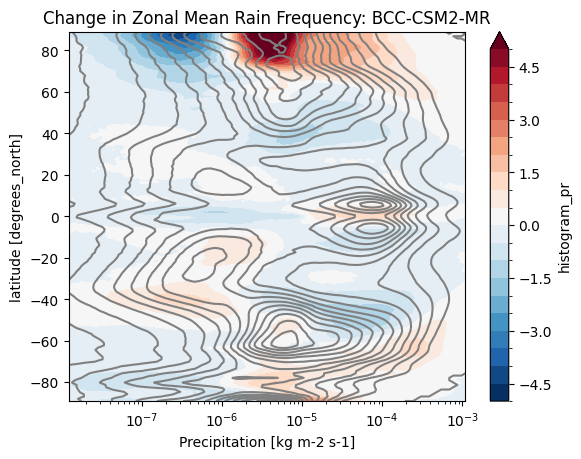

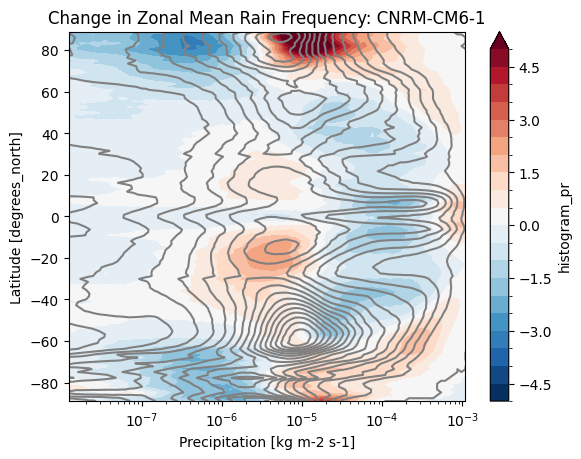

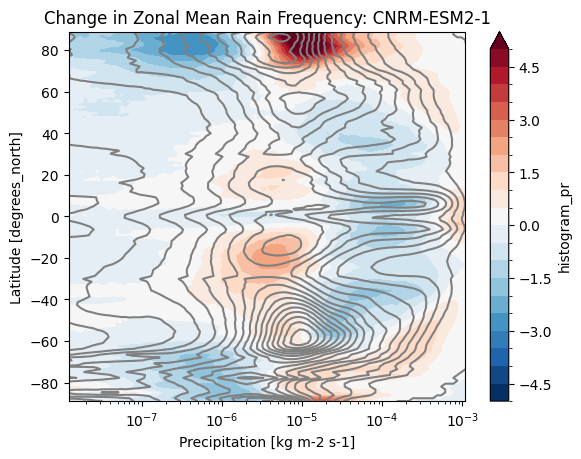

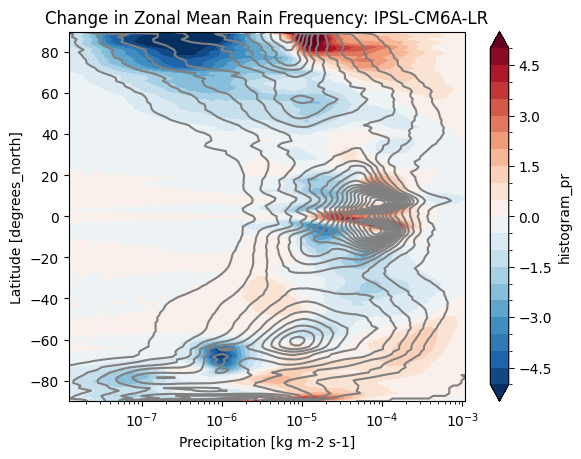

In [22]:
%%time
title = 'Change in Zonal Mean Rain Frequency'
for source_id, pr_hist in results.items():
    plt.figure()
    plot_precip_changes(pr_hist)
    plt.title(f'{title}: {source_id}')

In [23]:
cluster.close()